### Shakespeare Transformer
We just want it to babble vaguely like the Bard.

kernel to use:
```uv run ipython kernel install --user --env VIRTUAL_ENV $(pwd)/.venv --name=transformers_torch_kernel```

In [174]:
from typing import Optional
import math
from collections import OrderedDict
import re
import urllib

import matplotlib
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from einops import rearrange, einsum

torch.manual_seed(1234)
device = torch.device("mps") if torch.mps.is_available() else torch.device("cpu")
device = torch.device("cuda") if torch.cuda.is_available() else device

In [175]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

def plot_grad_flow(named_parameters):
    avg_grads = []
    max_grads = []
    layers = []
    for n, p in named_parameters:
        if p.requires_grad and "bias" not in n:
            layers.append(n)
            avg_grads.append(p.grad.abs().mean().cpu())
            max_grads.append(p.grad.abs().max().cpu())
    
    plt.bar(np.arange(len(max_grads)), max_grads, alpha = 0.1, lw=1, color="c")
    plt.bar(np.arange(len(avg_grads)), avg_grads, alpha = 0.1, lw=1, color="b")
    plt.hlines(0, 0, len(avg_grads)+1, lw=2, color="k")
    plt.xticks(range(0, len(avg_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(avg_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

In [176]:
"""
Dimension key:
L: sequence length
D: model dimension (d_model)
V: vocabulary size
F: feed-forward subnetwork's hidden size
K: size of each attention key or value (d_k,d_v,d_kv)
"""

"\nDimension key:\nL: sequence length\nD: model dimension (d_model)\nV: vocabulary size\nF: feed-forward subnetwork's hidden size\nK: size of each attention key or value (d_k,d_v,d_kv)\n"

In [177]:
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000) -> None:
        """Construct the entire positional encoding."""
        super().__init__()
        w = torch.exp(torch.arange(0, d_model, 2) * ((-1/d_model) * math.log(10000)))
        PE = torch.zeros([max_len, d_model])
        positions = torch.arange(0, max_len)
        # We have 2 vectors
        assert (positions.shape == (max_len,))
        assert (w.shape == (d_model // 2,))
        positions = rearrange(positions, "(len column) -> len column", column=1)
        PE[:, 0::2] = torch.sin(positions * w)
        PE[:, 1::2] = torch.cos(positions * w)
        self.register_buffer("PE", PE) # this is not to be a learnable parameter
        # However we do want it to be moved along with model.to(device) 
    
    def forward(self, x):
        _, L, D = x.shape
        x += self.PE[:L, :D]
        return x

In [178]:
class EmbeddingLayer(nn.Module):
    def __init__(self, vector_size: int, vocab_size: int):
        super().__init__()
        self.d_model = vector_size
        self.scaling_factor = math.sqrt(self.d_model) # a detail in the paper
        self.lut = nn.Embedding(vocab_size, vector_size)
    
    def forward(self, input_indices: torch.Tensor):
        return self.lut(input_indices) * self.scaling_factor

    def get_weights(self):
        return self.lut.weight

In [179]:
class MultiHeadedSelfAttention(nn.Module):
    def __init__(self, n_heads:int, d_head: int):
        super().__init__()
        self.n_heads = n_heads
        self.scale_factor = math.sqrt(d_head)
    
    def forward(self, Q_BHLK, K_BHLK, V_BHLK) -> torch.Tensor:
        assert (Q_BHLK.shape == K_BHLK.shape)

        K_BHKL = rearrange(K_BHLK, "b nh s dh -> b nh dh s")
        scaled_qk_BHLL = einsum(Q_BHLK, K_BHKL, "b nh s_q dh, b nh dh s_k -> b nh s_q s_k") / (self.scale_factor)
        if self.training:
            L = scaled_qk_BHLL.shape[-1]
            mask = torch.tril(torch.ones(L, L, device=scaled_qk_BHLL.device)).bool()
            mask = mask.unsqueeze(0).unsqueeze(0)
            scaled_qk_BHLL = scaled_qk_BHLL.masked_fill(~mask, float('-inf'))
            # tril_qk = torch.tril(scaled_qk_BHLL)
            # scaled_qk_BHLL = torch.where(tril_qk == 0, float("-inf"), scaled_qk_BHLL)
        
        weighted_keys_BHLL = torch.softmax(scaled_qk_BHLL, dim=-1)
        attention_output_BHLV = einsum(weighted_keys_BHLL, V_BHLK, "b nh s_q s_k,  b nh s_k dh -> b nh s_q dh")

        return attention_output_BHLV

In [180]:
class FeedForward(nn.Module):
    def __init__(self, D: int, H: int = 2048):
        super().__init__()
        self.layers = nn.Sequential(OrderedDict([
            ("linear1", nn.Linear(D, H)),
            ("relu1", nn.ReLU()),
            ("linear2", nn.Linear(H, D)),
        ]))
    
    def forward(self, x):
        return self.layers.forward(x)

class Decoder(nn.Module):
    def __init__(self, d_model: int, d_k: int, P_drop: int, n_heads: int):
        super().__init__()
        # attention function
        self.d_model = d_model
        self.d_head = d_k // n_heads
        self.P_drop = P_drop
        self.W_query_HDK = nn.Parameter(torch.randn([n_heads, self.d_model, self.d_head]), requires_grad=True)
        self.W_key_HDK = nn.Parameter(torch.randn([n_heads, self.d_model, self.d_head]), requires_grad=True)
        self.W_value_HDK = nn.Parameter(torch.randn([n_heads, self.d_model, self.d_head]), requires_grad=True)
        self.W_output_DD = nn.Parameter(torch.randn([n_heads * self.d_head, self.d_model]), requires_grad=True)
        nn.init.kaiming_uniform_(self.W_query_HDK)
        nn.init.kaiming_uniform_(self.W_key_HDK)
        nn.init.kaiming_uniform_(self.W_value_HDK)
        nn.init.kaiming_uniform_(self.W_output_DD)

        self.attn = MultiHeadedSelfAttention(n_heads=n_heads, d_head=self.d_head)

        # normalize over the last dimension in shape [N, d_v], so each layer
        self.dropout1 = nn.Dropout(p=self.P_drop)
        self.layernorm1 = nn.LayerNorm(self.d_model)
        self.feedforward = FeedForward(D=self.d_model)
        self.dropout2 = nn.Dropout(p=self.P_drop)
        self.layernorm2 = nn.LayerNorm(self.d_model)
    
    def forward(self, input_BLD: torch.Tensor) -> torch.Tensor:
        assert(input_BLD.dim() == 3 and input_BLD.shape[-1] == self.d_model)
        input_token_length = input_BLD.shape[1]

        Query_BHLK = einsum(input_BLD, self.W_query_HDK, "b s dm, nh dm dh -> b nh s dh")
        Key_BHLK = einsum(input_BLD, self.W_key_HDK,"b s dm, nh dm dh -> b nh s dh")
        Value_BHLK = einsum(input_BLD, self.W_value_HDK, "b s dm, nh dm dh -> b nh s dh")

        attn_values_BHLV = self.attn(Query_BHLK, Key_BHLK, Value_BHLK)

        concat_attn_values_BLV = rearrange(attn_values_BHLV, "b nh s dh -> b s (nh dh)")
        output_attn_values_BLV = einsum(concat_attn_values_BLV, self.W_output_DD, "b s nhdh, nhdh dm -> b s dm")

        reg_attn_values_BLV = self.dropout1(output_attn_values_BLV)
        normalized_attn_values_BLV = self.layernorm1(reg_attn_values_BLV + input_BLD)
        assert(normalized_attn_values_BLV.shape == reg_attn_values_BLV.shape)
        assert(normalized_attn_values_BLV.dim() == 3 and normalized_attn_values_BLV.shape[-1] == self.d_model)

        ffn_BLD = self.feedforward(normalized_attn_values_BLV)
        reg_ffn_BLD = self.dropout2(ffn_BLD)

        normalized_ffn_BLD = self.layernorm2(reg_ffn_BLD + normalized_attn_values_BLV)
        return normalized_ffn_BLD
    

In [181]:
class Transformer(nn.Module):
    def __init__(self, d_model: int = 512, num_decoders: int = 6, n_heads=4, P_drop: float = 0.1, vocabulary_size: int = 10000):

        super().__init__()
        assert (num_decoders >= 1)
        self.d_model = d_model
        self.d_k = d_model

        self.positional_encodings = SinusoidalPositionalEncoding(d_model=self.d_model)

        self.emb_dropout = nn.Dropout(p = P_drop)
        self.embed = EmbeddingLayer(vector_size=self.d_model, vocab_size=vocabulary_size)
        self.decoder_stack = nn.Sequential()
        for _ in range(num_decoders):
            self.decoder_stack.append(Decoder(d_model = self.d_model, d_k=self.d_k, P_drop = P_drop, n_heads=n_heads))

        self.linear = nn.Linear(self.d_model, vocabulary_size)
        self.linear.weight = self.embed.lut.weight
        self.logsoftmax = nn.LogSoftmax(dim=-1) # this is LogSoftmax so we can get the NLLLoss
    
    def forward(self, input_tokens_BL: torch.Tensor):
        assert(input_tokens_BL.dim() == 2 and input_tokens_BL.dtype == torch.int)
        B, L = input_tokens_BL.shape
        embed_tokens_BLD = self.embed(input_tokens_BL)
        assert(embed_tokens_BLD.dim() == 3 and embed_tokens_BLD.shape == torch.Size([B, L, self.d_model]))

        embed_tokens_BLD = self.positional_encodings(embed_tokens_BLD)

        decoder_output_BLD = self.decoder_stack(embed_tokens_BLD)

        assert(decoder_output_BLD.dim() == 3 and decoder_output_BLD.shape == torch.Size([B, L, self.d_model]))
        linear_output_BLV = self.linear(decoder_output_BLD)
        next_token_probabilities_BLV = self.logsoftmax(linear_output_BLV)

        return next_token_probabilities_BLV # this is of shape [seq_len, vocab_size] (each token has computed a probabilistic next token)
        """Now we map these back to the words based on the maximum token."""


In [182]:
def train_loop(train_dl,
               model: torch.nn.Module,
               loss_fn,
               optimizer,
               device,
               epochs,
               train_ds_len: int,
               scheduler: torch.optim.lr_scheduler,
               sequence_length: int,
               val_dl,
               val_ds_len: int
    ):
    record_train_loss = []
    record_train_accuracy = []
    record_val_loss = []
    record_val_accuracy = []
    for ep in range(epochs):
        train_loss, train_accuracy, test_loss, test_accuracy = 0, 0, 0, 0

        model.train()
        for idx, (batch, labels) in enumerate(train_dl):
            batch_BL, labels_BL = batch.to(device), labels.to(device)

            optimizer.zero_grad()
            # No shifting
            next_token_prob_BLV = model(batch_BL)

            next_token_prob_BVL = rearrange(next_token_prob_BLV, "B L V -> B V L")

            loss = loss_fn(next_token_prob_BVL, labels_BL.to(torch.long))
            loss.backward()
            optimizer.step()
            if idx == 20:
                print(f"Learning Rate: {scheduler.get_last_lr()}")
                plot_grad_flow(model.named_parameters())

            train_loss += loss.item()
            train_accuracy += (next_token_prob_BLV.argmax(-1) == labels_BL).sum().item()
        scheduler.step()
        record_train_loss.append(train_loss/train_ds_len)
        record_train_accuracy.append(train_accuracy / (train_ds_len*sequence_length))
        
        model.eval()
        for idx, (val_batch, val_labels) in enumerate(val_dl):
            # No shifting
            with torch.no_grad():
                val_batch_BL, val_labels_BL = val_batch.to(device), val_labels.to(device)
                val_next_token_prob_BLV = model(val_batch_BL)
                val_next_token_prob_BVL = rearrange(val_next_token_prob_BLV, "B L V -> B V L")

                val_loss = loss_fn(val_next_token_prob_BVL, val_labels_BL.to(torch.long))

                test_loss += val_loss.item()
                test_accuracy+= (val_next_token_prob_BLV.argmax(-1) == val_labels_BL).sum().item()
        record_val_loss.append(test_loss / val_ds_len)
        record_val_accuracy.append(test_accuracy / (val_ds_len * sequence_length))

        if ep % 5 == 0:
            print(f"Epoch {ep}:")
            print(f"Loss = {record_train_loss[ep]} Accuracy = {record_train_accuracy[ep]}")
            print(f"Val Loss = {record_val_loss[ep]} Val Accuracy = {record_val_accuracy[ep]}")

    return record_train_loss, record_val_loss, record_train_accuracy, record_val_accuracy



In [183]:
def test_loop(dataloader, model: torch.nn.Module, loss_fn, device):
    size = len(dataloader)
    print(f"Test set samples: {size}")
    model.eval()
    test_loss, correct = 0, 0
    total_tokens = 0
    with torch.no_grad():
        for idx, (batch, labels) in enumerate(dataloader):
            total_tokens += batch.numel()
            batch_BL, flipped_BL = batch.to(device), labels.to(device)
            # No shifting
            next_token_prob_BLV = model(batch_BL)

            next_token_prob_BVL = next_token_prob_BLV.transpose(1, 2)

            test_loss += loss_fn(next_token_prob_BVL, flipped_BL.to(torch.long)).item()
            correct += (next_token_prob_BLV.argmax(dim=-1) == flipped_BL).sum().item()
    
    test_loss /= total_tokens
    correct /= total_tokens
    print(f"Test error: Accuracy: {100*correct}, Avg loss: {test_loss}\n")

In [184]:
with urllib.request.urlopen("https://www.gutenberg.org/files/100/100-0.txt") as f:
    lines = [x.decode("utf-8") for x in f]

start_mark = "*** START OF THE PROJECT GUTENBERG EBOOK 100 ***\r\n"
end_mark = "*** END OF THE PROJECT GUTENBERG EBOOK 100 ***\r\n"
start_loc, end_loc = lines.index(start_mark), lines.index(end_mark)
start_loc, end_loc

(0, 196016)

In [185]:
useful_lines = lines[start_loc+1: end_loc]
corpus = " ".join(useful_lines).lower()
corpus_tokens = re.split(r"\b", corpus)


In [186]:
train_ratio = 0.9
train_corpus = corpus_tokens[:int(train_ratio * len(corpus_tokens))]
val_corpus = corpus_tokens[int(train_ratio * len(corpus_tokens)):]
print(len(train_corpus), len(val_corpus))
print(train_corpus[:10])
print(val_corpus[:10])

1787228 198581
['', 'the', ' ', 'complete', ' ', 'works', ' ', 'of', ' ', 'william']
['?\r\n \r\n ', 'valentine', '.\r\n ', 'wise', '.\r\n \r\n ', 'thurio', '.\r\n ', 'what', ' ', 'instance']


In [187]:
DEBUG = False
if DEBUG:
    train_corpus = train_corpus[:512]
    val_corpus = val_corpus[:512]

In [188]:
UNKNOWN_TOK = "UNKNOWN"
vocab = sorted([UNKNOWN_TOK] + list(set(corpus_tokens)))
ss_vocab_size = len(vocab)
print(ss_vocab_size)

26471


In [189]:
# token word to id conversion and vice versa
token_to_id_map = dict(zip(vocab, range(len(vocab))))
id_to_token_map = {v: k for k, v in token_to_id_map.items()}

In [190]:
def ids_to_token(ids, id_token_map):
    return "".join([id_token_map[id.item()] for id in ids])

In [203]:
train_ids = torch.tensor([token_to_id_map[x] for x in train_corpus], dtype=torch.int)
val_ids = torch.tensor([token_to_id_map.get(x, token_to_id_map[UNKNOWN_TOK]) for x in val_corpus], dtype=torch.int)

In [204]:
class ShakespeareDataset(torch.utils.data.Dataset):
    def __init__(self, ids: list[int], L: int):
        super().__init__()
        self.ids = ids
        self.chunk_idxes = list(range(0, len(self.ids)-L, L))
        self.L = L
    
    def __len__(self):
        return len(self.chunk_idxes)
    
    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        # Retrieve a sample at `idx` consisting of sample, label
        chunk = self.ids[self.chunk_idxes[idx]:self.chunk_idxes[idx]+self.L]

        #OVERFIT MODE
        # chunk = self.ids[0:0+self.L+1]
        # add padding if sample is too small
        # if int(chunk.shape) != self.L:


        sample = chunk[:-1].clone().detach() # the i/p should be each sample except the next one
        labels = chunk[1:].clone().detach() # the o/p should be the next token for each, left padded
        # think about it
        # for the first sample we expect to get the second character and so on.
        return sample, labels


In [205]:
batch_size = 1
SEQUENCE_LEN_L = 128
train_ds = ShakespeareDataset(train_ids, L=SEQUENCE_LEN_L)
val_ds = ShakespeareDataset(val_ids, L=SEQUENCE_LEN_L)
print(len(train_ds), len(val_ds))

13962 1551


In [206]:
print(ids_to_token(train_ds[1][0], id_token_map=id_to_token_map))
print(ids_to_token(train_ds[1][1], id_token_map=id_to_token_map))

 henry the fifth
     the first part of henry the sixth
     the second part of king henry the sixth
     the third part of king henry the sixth
     king henry the eighth
     the life and death of king john
     the tragedy of julius caesar
     the tragedy of king lear
     love’s labour’s lost
     the tragedy of macbeth
     measure for measure
     the merchant of venice
     
henry the fifth
     the first part of henry the sixth
     the second part of king henry the sixth
     the third part of king henry the sixth
     king henry the eighth
     the life and death of king john
     the tragedy of julius caesar
     the tragedy of king lear
     love’s labour’s lost
     the tragedy of macbeth
     measure for measure
     the merchant of venice
     the


In [207]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
print(len(train_dl), len(val_dl))

13962 1551


In [208]:
shakespeare_model = Transformer(num_decoders=8, d_model=512, vocabulary_size=ss_vocab_size, n_heads=8, P_drop=0.3).to(device)

In [209]:
loss = F.nll_loss
adam_opt = torch.optim.Adam(shakespeare_model.parameters(), betas=(0.9, 0.98), eps=1e-09, lr=0.0006) # parameters from paper. No LR schedule, default 0.001
scheduler = torch.optim.lr_scheduler.LinearLR(adam_opt)

Learning Rate: [0.00019999999999999998]
Epoch 0:
Loss = 6.163653755884699 Accuracy = 0.3671623200472712
Val Loss = 4.908001918011831 Val Accuracy = 0.33825959058671823
Learning Rate: [0.00028]
Learning Rate: [0.00035999999999999997]
Learning Rate: [0.00044]
Learning Rate: [0.0005200000000000001]
Learning Rate: [0.0006000000000000001]
Epoch 5:
Loss = 5.277975969884239 Accuracy = 0.3484580916057871
Val Loss = 5.608051887256418 Val Accuracy = 0.35394503546099293
Learning Rate: [0.0006000000000000001]
Learning Rate: [0.0006000000000000001]
Learning Rate: [0.0006000000000000001]
Learning Rate: [0.0006000000000000001]


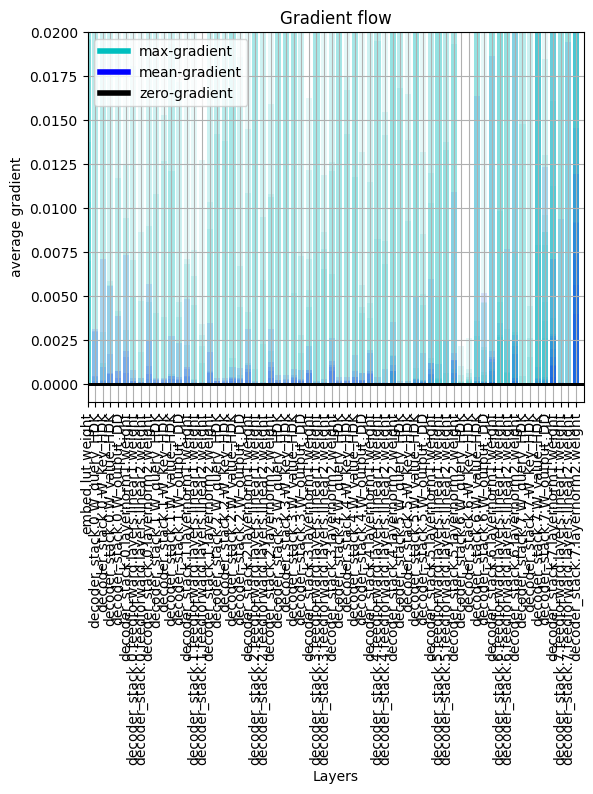

In [210]:
epochs = 10

losses = train_loop(
    train_dl=train_dl,
    model=shakespeare_model,
    loss_fn=loss,
    optimizer=adam_opt,
    scheduler=scheduler,
    device=device,
    epochs=epochs,
    train_ds_len=len(train_ds),
    sequence_length=SEQUENCE_LEN_L,
    val_dl=val_dl,
    val_ds_len=len(val_ds),
)

In [211]:
def plot_results(train_losses, valid_losses, train_accs, valid_accs):
  fig, ax = plt.subplots(1,1,figsize=(16,6))
  ax.set_title("Losses & Accuracy")
  ax2 = ax.twinx()
  ax.plot(train_losses, label="train_loss")
  ax.plot(valid_losses, label="valid_loss")
  ax.set_ylabel("loss")

  ax2.plot(train_accs, "--", label="train_acc")
  ax2.plot(valid_accs, "--", label="valid_acc")
  ax2.set_ylabel("accuracy")

  ax.legend(loc=2)
  ax2.legend(loc=1)
  plt.xlabel("epoch")
  plt.show()

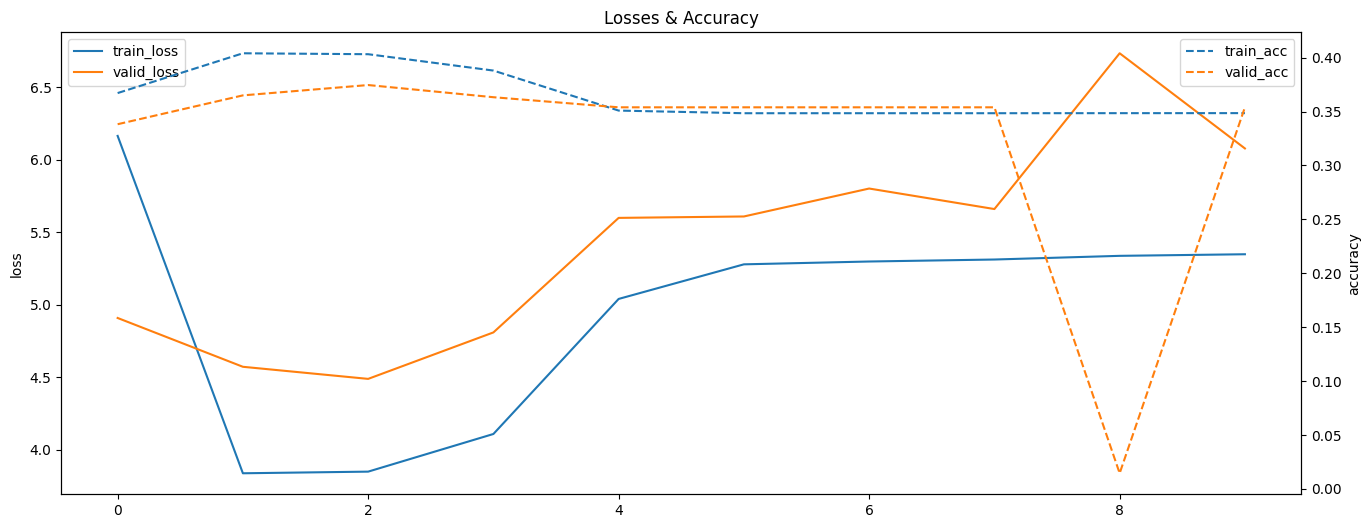

In [212]:
plot_results(*losses)